### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 15th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3.5 to 6.5. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to $\mu+\sigma_\mathrm{mean}$ and $\mu-\sigma_\mathrm{mean}$. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.5 to 5.5. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6.1\pm0.25$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6.1$ with standard deviation of $0.25$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [79]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
import time

# MRS Load in the data
data = np.load('../../../homeworks/hw_data/hw4_data_1.npy')
voltage = data[:,0]
uncert = data[:,1]

# MRS Calculating and printing the mean and sigma of the data
mean = np.sum(voltage / uncert**2) / np.sum(1/uncert**2)
sig_mu = 1 / np.sqrt(np.sum(1/uncert**2))

print(mean, sig_mu)


4.942118214425304 0.43024334605205083


In [80]:
# MRS Define the log-likelihood function of a gaussian distribution
def lnL(vals, uncert, mu):
    lnL = np.sum(-1/2 * np.log(2*np.pi*uncert**2)) - np.sum((vals - mu)**2/(2*uncert**2))
    return lnL

# MRS lambda function for my log-likelihood
f_fit = lambda beta: -lnL(voltage, uncert, beta[0])

# MRS find the best mean value by optimizing the ln-likelihood function
beta0 = mean
beta_gauss = optimize.fmin(f_fit, beta0, full_output=True)
print("Best Fit Mean: ", beta_gauss[0][0])

Optimization terminated successfully.
         Current function value: 16.048013
         Iterations: 13
         Function evaluations: 26
Best Fit Mean:  4.942118214425304


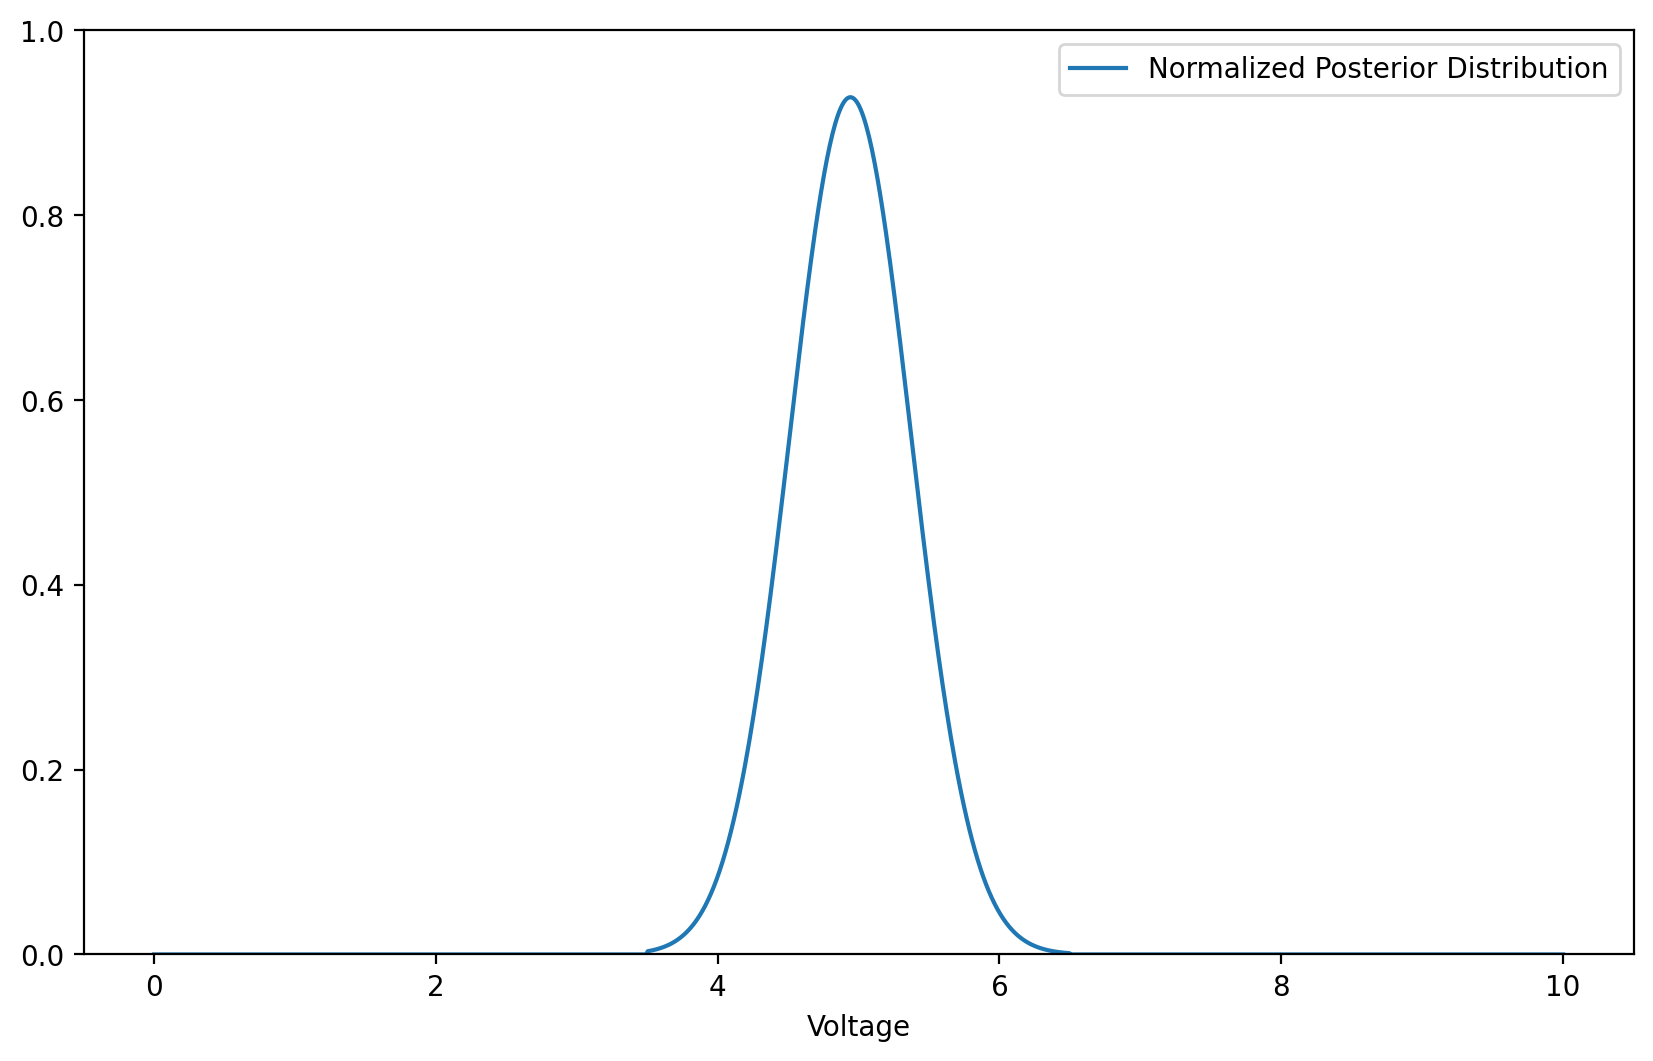

In [81]:
#prior (ignore loc and scale until the beta prior)
import scipy.integrate 

# MRS Defining a function for a uniform distribution over the range (loc, loc+scale)
def prior(x, loc, scale):
    return uniform(loc, scale).pdf(x)


# MRS Plotting the posterior
fig, ax = plt.subplots(figsize=(10,6))

# MRS all voltages to sample over
xgrid = np.linspace(0, 10, 1000)
post_uni1 = []  

# MRS Caclulating the un-normalized posterior distribution
for x in xgrid:
    post_uni1.append(np.exp(lnL(voltage, uncert, x)) * prior(x, 3.5, 3))  # Store values

post_uni1 = np.array(post_uni1) 
 
# MRS Integrate area under distribution to calculate evidence
area_uni1 = scipy.integrate.trapezoid(post_uni1, xgrid)

# MRS Plot normalized posterior distribution
ax.plot(xgrid, post_uni1/area_uni1, label=r'Normalized Posterior Distribution')

plt.ylim(0, 1)
plt.legend()
plt.xlabel('Voltage')
plt.show()




Upper and lower credible regions at 4.51 and 5.36
Mean-sig = 4.51, Mean+sig = 5.37 
The MAP is: 4.9449


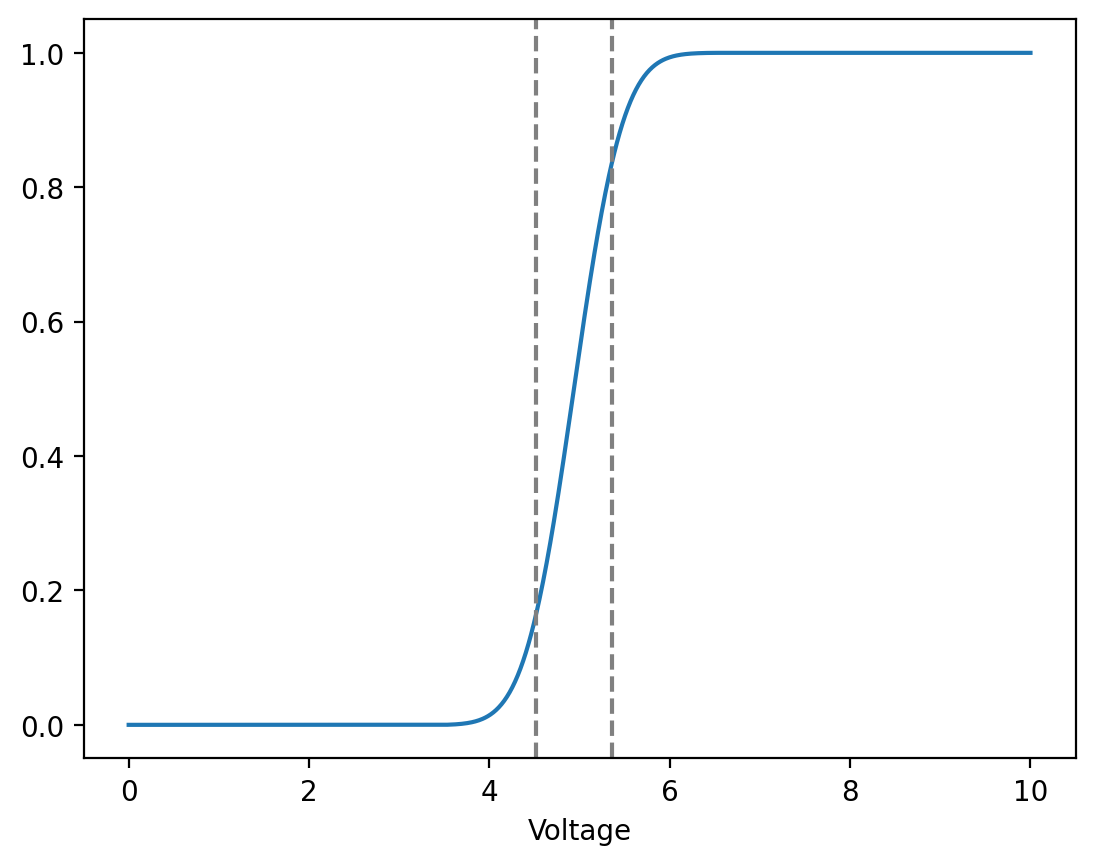

In [82]:
# MRS Calculate the normalized cummulative distribution function
cdf = np.cumsum(post_uni1) / np.sum(post_uni1)

# MRS Pull the first mean where the CDF is greater than 0.16
lower = xgrid[np.where(cdf >= .16)[0][0]]

# MRS Pull the last mean before CDF is 0.84
upper = xgrid[np.where(cdf <= .84)[0][-1]]

# MRS Plot the CDF with the equal-tailed 68.3% confidence intervals
plt.plot(xgrid, cdf)
plt.axvline(lower, linestyle='--', color='gray')
plt.axvline(upper, linestyle='--', color='gray')
plt.xlabel('Voltage')

print(f'Upper and lower credible regions at {lower:.2f} and {upper:.2f}\nMean-sig = {mean-sig_mu:.2f}, Mean+sig = {mean+sig_mu:.2f} ')

# MRS Find the mean where the posterior is maximized (MAP)
map = xgrid[np.argsort(post_uni1)[-1]]
print(f'The MAP is: {map:.4f}')

SRT: Very good

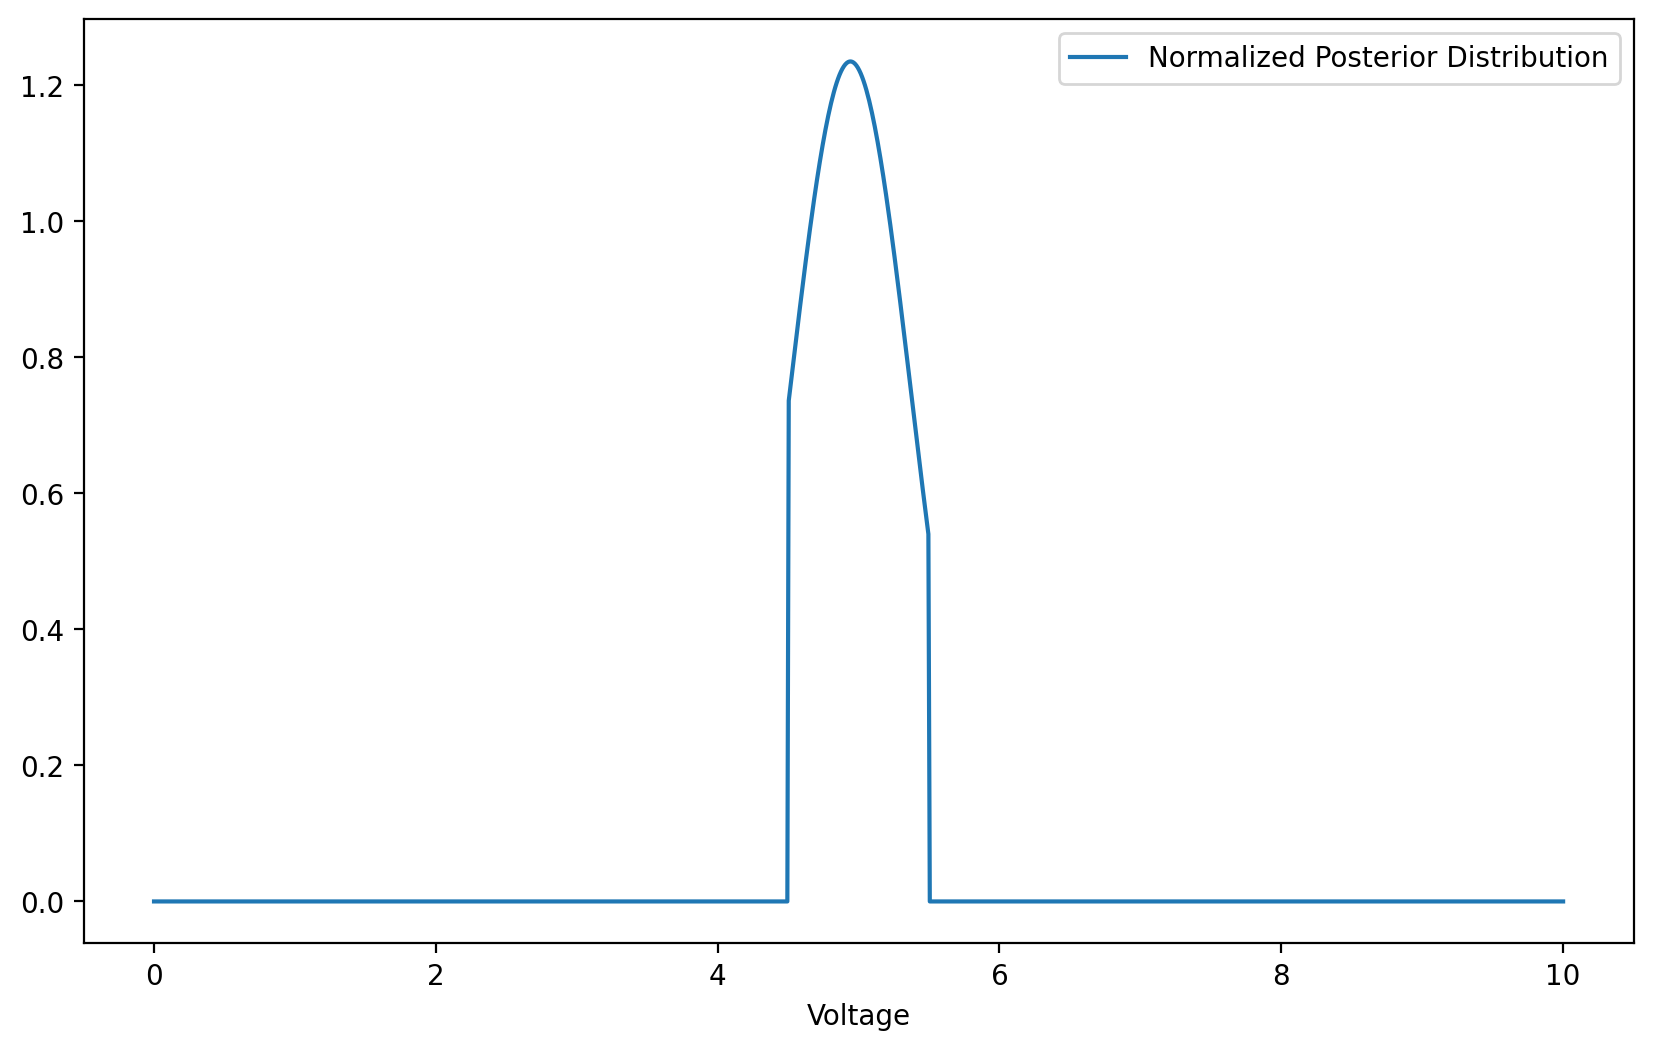

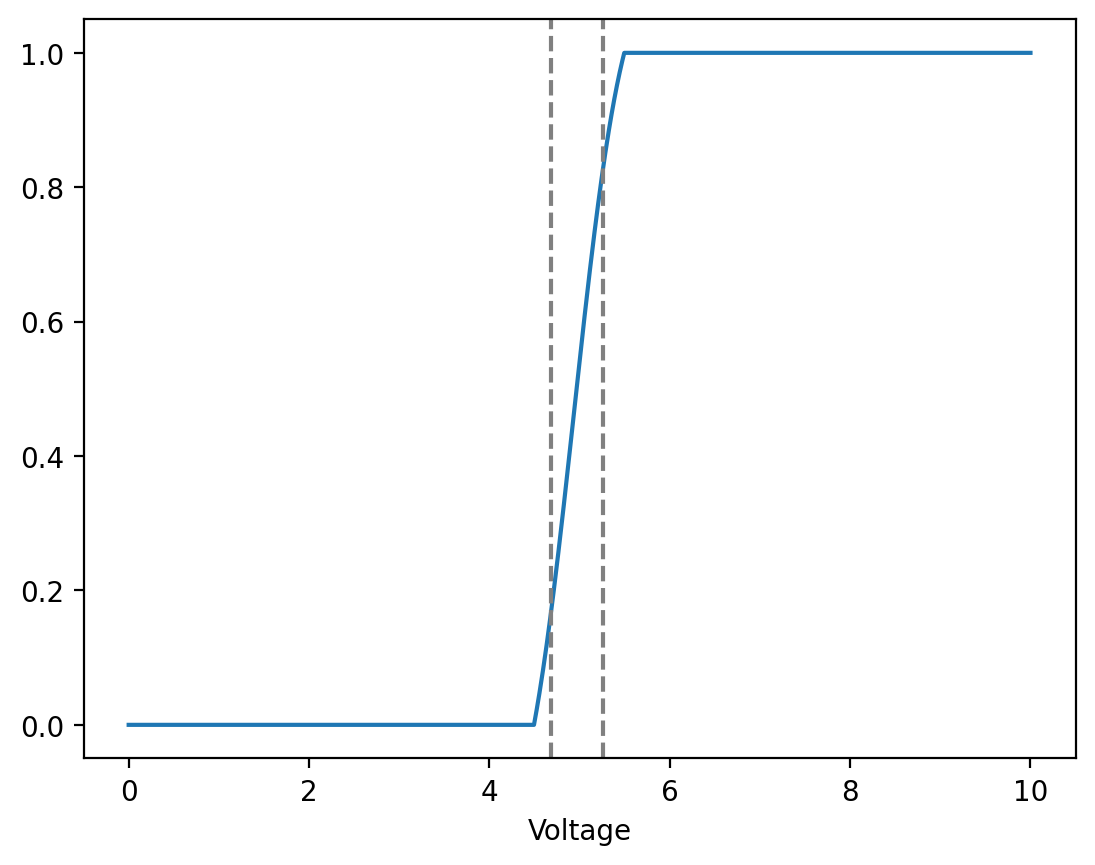

The MAP is: 4.9449


In [83]:
# MRS Part 
fig, ax = plt.subplots(figsize=(10,6))

post_uni2 = []  # Empty list to store posterior values

for x in xgrid:
    post_uni2.append(np.exp(lnL(voltage, uncert, x)) * prior(x, 4.5, 1))  # Store values

post_uni2 = np.array(post_uni2) 
 
#or 
##likelihood = np.exp([lnL(voltage, uncert, x) for x in xgrid])
#posterior = likelihood * prior(xgrid, 3.5, 3)

area_uni2 = scipy.integrate.trapezoid(post_uni2, xgrid)
#area2 = scipy.integrate.trapezoid(posterior, xgrid)
ax.plot(xgrid, post_uni2/area_uni2, label=r'Normalized Posterior Distribution')
#ax.plot(xgrid, posterior/area2, label=r'posterior dist')

# likelihood plot

#plt.ylim(0, 1)
plt.legend()
plt.xlabel('Voltage')
plt.show()

# CDF Is cumsum of PDF? 
cdf = np.cumsum(post_uni2) / np.sum(post_uni2)
lower = xgrid[np.where(cdf >= .16)[0][0]]
upper = xgrid[np.where(cdf <= .84)[0][-1]]

plt.plot(xgrid, cdf)
plt.axvline(lower, linestyle='--', color='gray')
plt.axvline(upper, linestyle='--', color='gray')
plt.xlabel('Voltage')
plt.show()

map = xgrid[np.argsort(post_uni2)[-1]]
print(f'The MAP is: {map:.4f}')


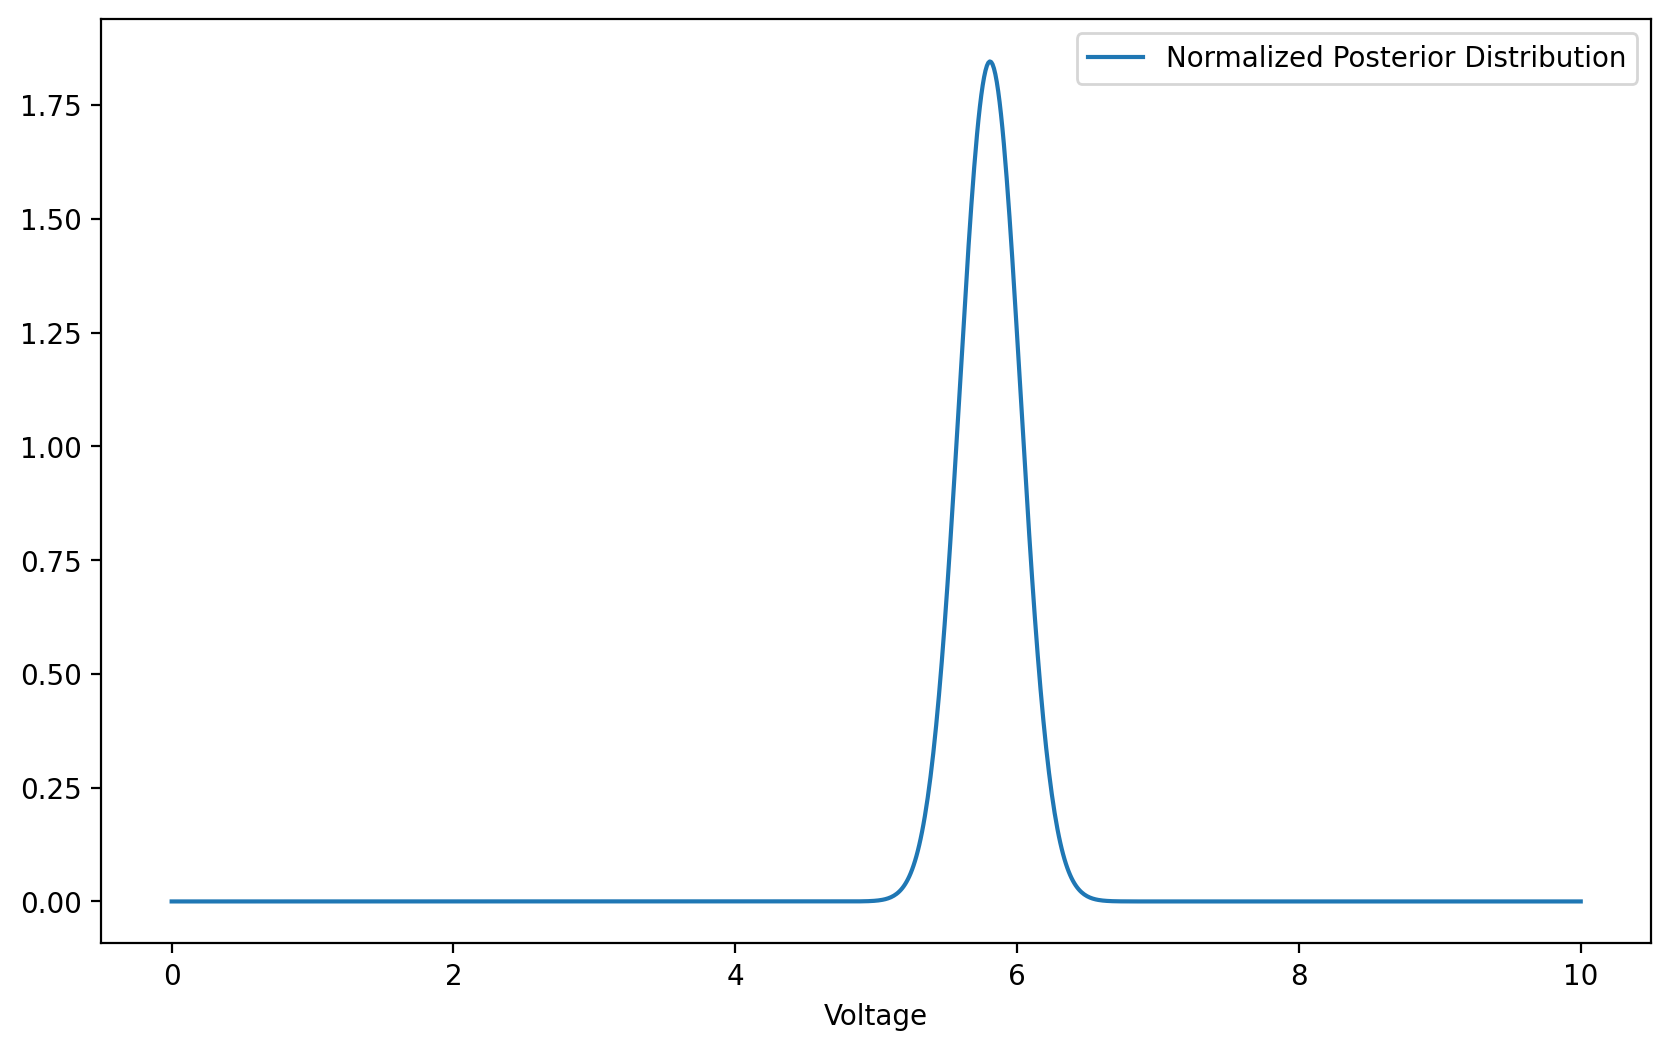

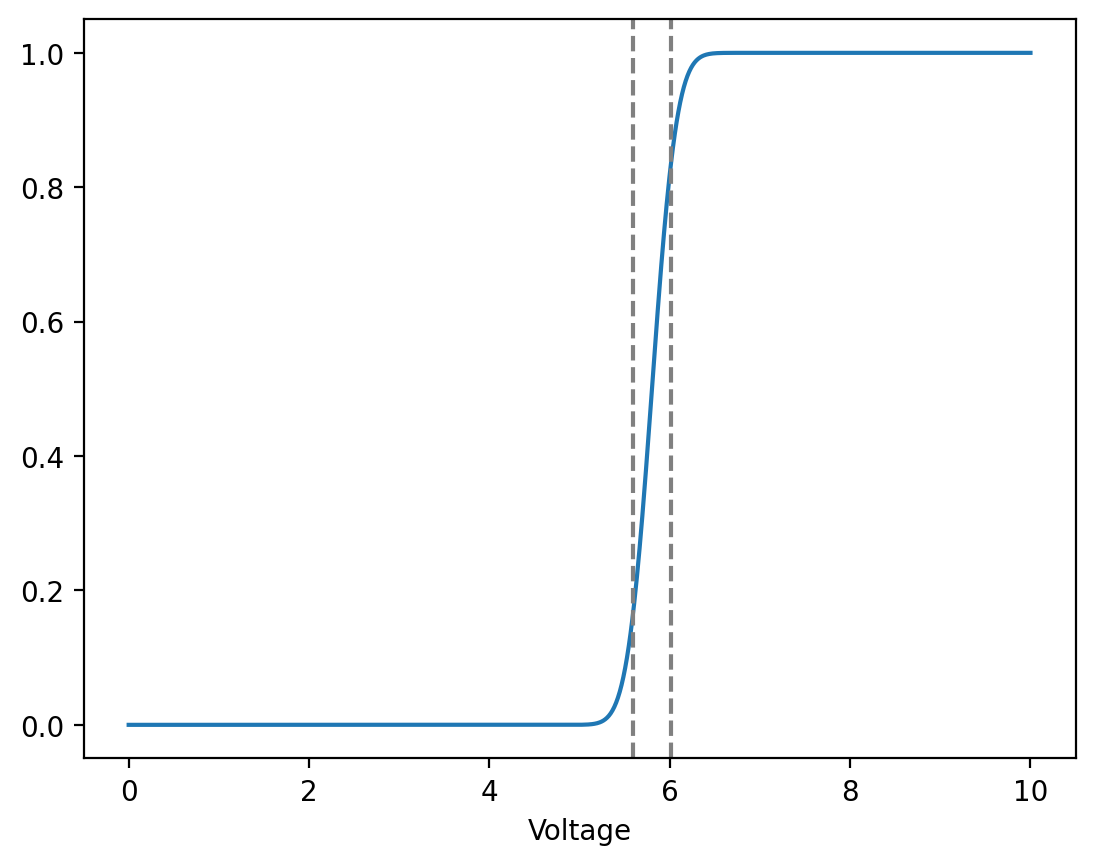

The MAP is: 5.8058


In [84]:
#prior (ignore loc and scale until the beta prior)
import scipy.integrate


def gauss_prior(x, mu, std):
    return norm.pdf(x, mu, std)


fig, ax = plt.subplots(figsize=(10,6))

post_gauss = []  # Empty list to store posterior values

for x in xgrid:
    post_gauss.append(np.exp(lnL(voltage, uncert, x)) * gauss_prior(x, 6.1, 0.25))  # Store values

post = np.array(post_gauss) 
 
#or 
##likelihood = np.exp([lnL(voltage, uncert, x) for x in xgrid])
#posterior = likelihood * prior(xgrid, 3.5, 3)

area_gauss = scipy.integrate.trapezoid(post_gauss, xgrid)
#area2 = scipy.integrate.trapezoid(posterior, xgrid)
ax.plot(xgrid, post_gauss/area_gauss, label=r'Normalized Posterior Distribution')
#ax.plot(xgrid, posterior/area2, label=r'posterior dist')

#plt.ylim(0, 1)
plt.legend()
plt.xlabel('Voltage')
plt.show()

# CDF Is cumsum of PDF? 
cdf = np.cumsum(post_gauss) / np.sum(post_gauss)
lower = xgrid[np.where(cdf >= .16)[0][0]]
upper = xgrid[np.where(cdf <= .84)[0][-1]]

plt.plot(xgrid, cdf)
plt.axvline(lower, linestyle='--', color='gray')
plt.axvline(upper, linestyle='--', color='gray')
plt.xlabel('Voltage')
plt.show()

map = xgrid[np.argsort(post_gauss)[-1]]
print(f'The MAP is: {map:.4f}')


/var/folders/ls/sw9901md6hg56d8jmwp77nyr0000gp/T/ipykernel_12434/277631685.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


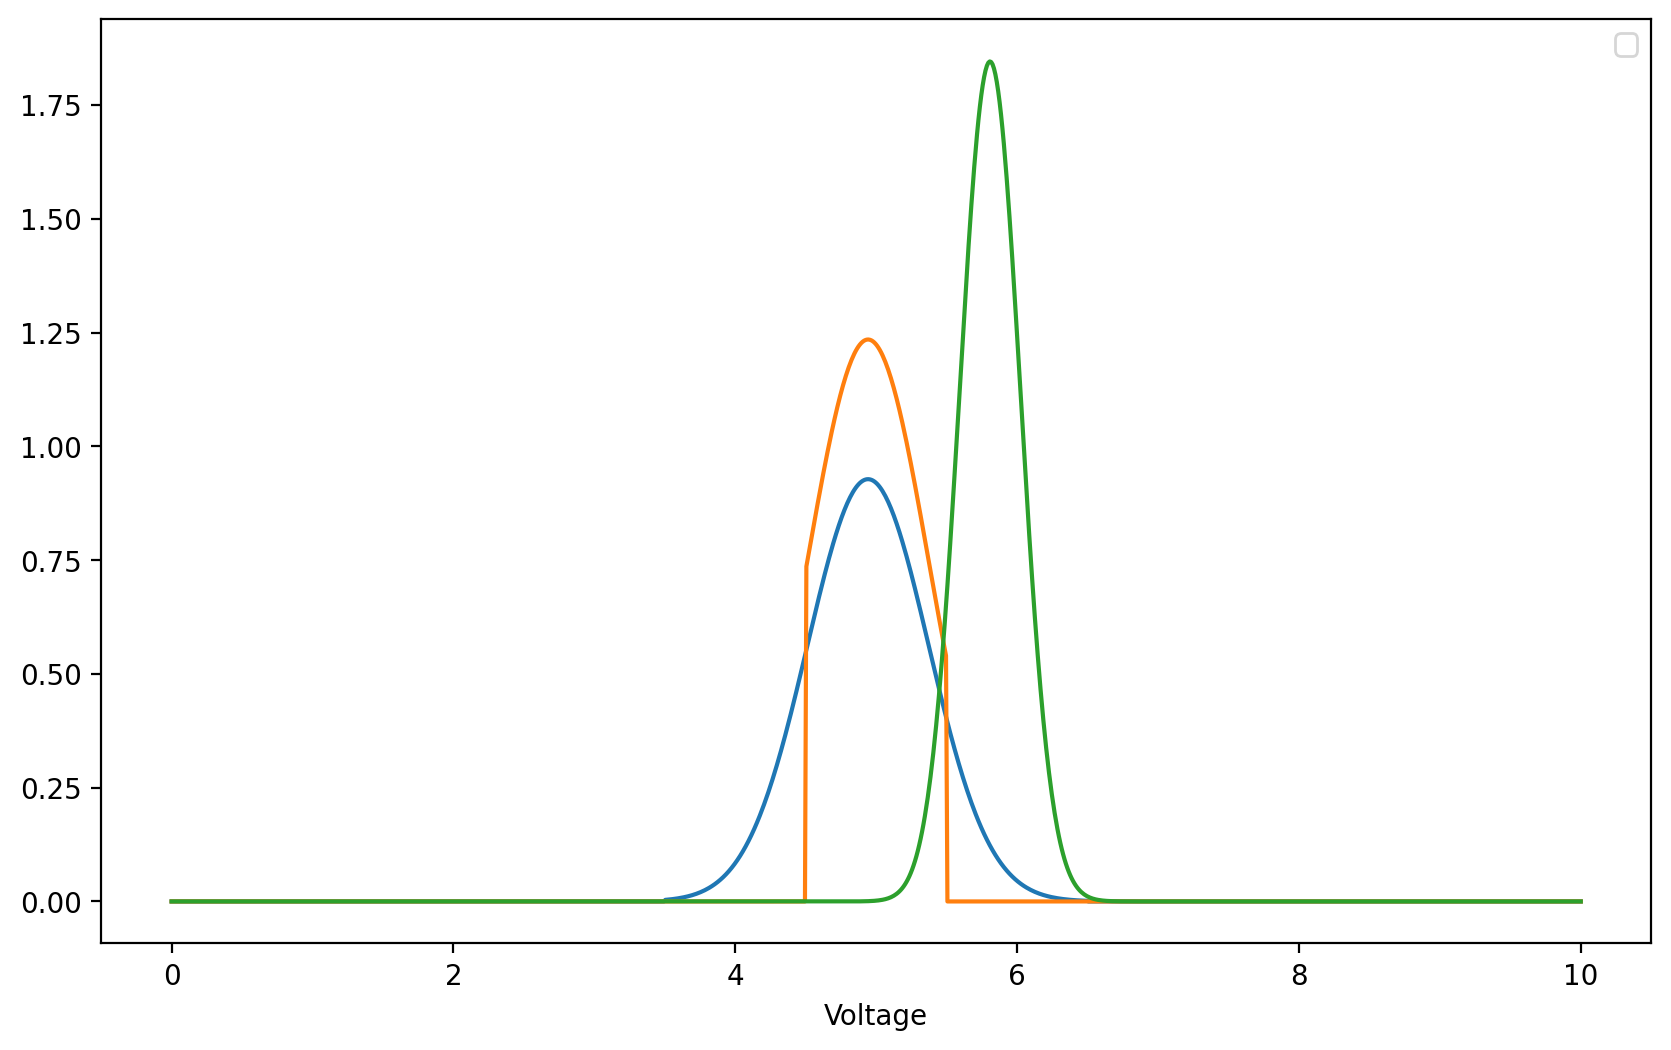

In [85]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(xgrid, post_uni1/area_uni1)
ax.plot(xgrid, post_uni2/area_uni2)
ax.plot(xgrid, post_gauss/area_gauss)

#plt.ylim(0, 1)
plt.legend()
plt.xlabel('Voltage')
plt.show()

If we are finding the evidence as the area under the curve, that is also just the integral of the likelihood times the prior.

Since we have a delta function on the best-fit mean value from (1), this means that the delta function will just come out of the integral as all of our probability is at the delta function. 

$${\rm Posterior \,\, Probability} = \frac{{\rm Likelihood}\times{\rm Prior}}{{\rm Evidence}}.$$

and we are saying that,

$$ \rm Evidence = \int {\rm Likelihood}\times{\rm Prior} $$

Where if our prior is a delta function $\delta(\mu - \mu_{\rm best})$, then this will just come out of the integral as the prior at the location of the mean, or our likelihood evaluated at the best fit mean.



In [86]:

# our evidence is just the likelihood evaluated at the mean found in (1) 
evidence = np.exp(lnL(voltage, uncert, mean)) 

# The evidence from (3) is the area calculated used to normalize the posterior distribution.
# A Bayes Factor will be the evidence of the delta prior over the evidence of the uniform prior.
bayes_fact = evidence / area_uni1

print(f'Bayes factor: {bayes_fact:.3f}')
print('This Bayes Factor is >1 favoring the delta function prior.')

Bayes factor: 2.783
This Bayes Factor is >1 favoring the delta function prior.


SRT: Nice

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [87]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in Lecture 9? 

### Solution

In [88]:
# MRS Load in the data
data = np.load('../../../homeworks/hw_data/hw4_data_2.npy')


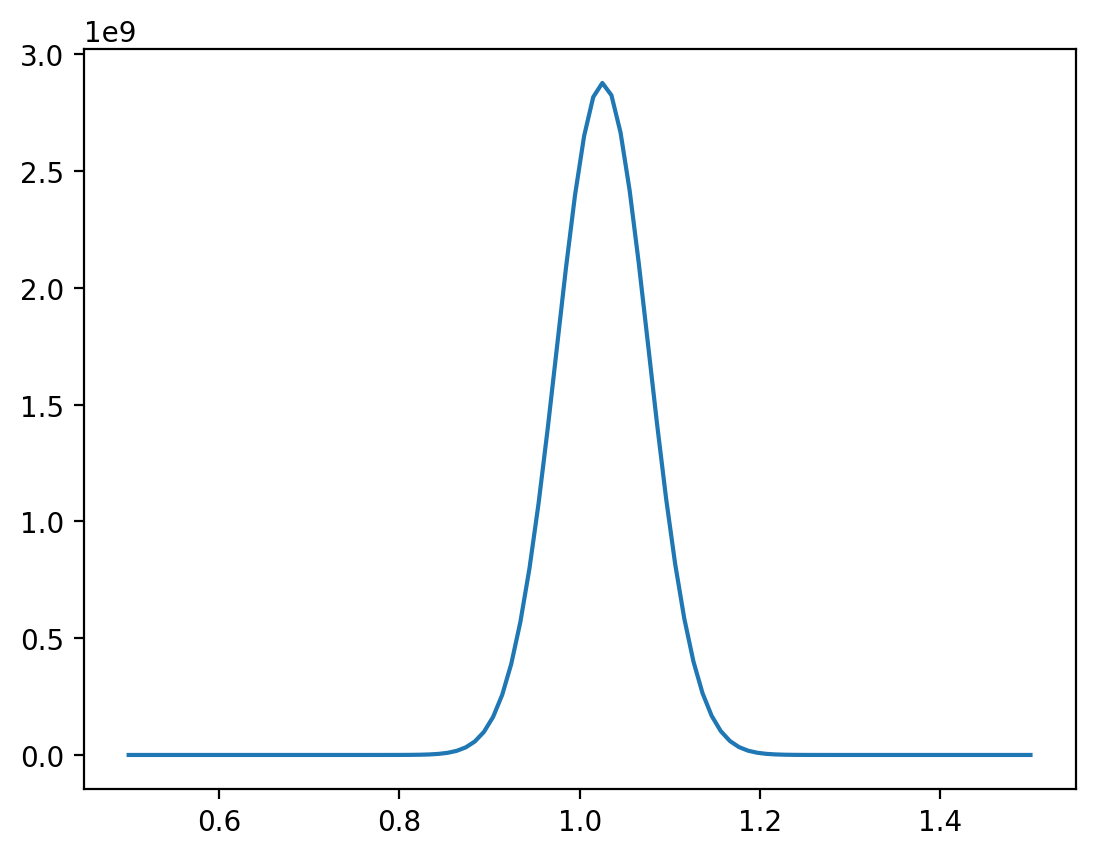

In [89]:
# MRS Initialize range of slopes (linear coefficient) to test over
slope_grid = np.linspace(0.5,1.5, 100)

# MRS Calculate the likelihood and then posterior distribution for these slope values
likelihood = np.exp([logL([-0.23, m], data) for m in slope_grid])
posterior = likelihood * prior(slope_grid, 0.5, 1)

# MRS Plot the posterior
plt.plot(slope_grid, posterior)

# MRS Bayseian Evidence is the area under the posterior distribution
evidence = scipy.integrate.trapezoid(posterior, slope_grid)

In [90]:
# MRS Define the ranges to test for the linear and quadratic coefficients 
linear_coeff = np.linspace(0.5,1.5, 100)
quad_coeff = np.linspace(-1, 0.25, 100)

# MRS calculate the likelihood and posterior for every combination of linear coefficient and quadratic coefficient
likelihood_gauss = np.array([[np.exp(logL([-0.23, m, n], data)) for m in linear_coeff] for n in quad_coeff])
posterior = likelihood_gauss * prior(linear_coeff, 0.5, 1) * prior(quad_coeff, -1, 1.25)

# MRS If I didn't have to pull out the likelihood this would have been my efficient one-liner
#posterior = np.array([[np.exp(logL([-0.23, m, n], data)) * prior(m, 0.5, 1) * prior(n, -1, 1.25) for m in linear_coeff] for n in quad_coeff])

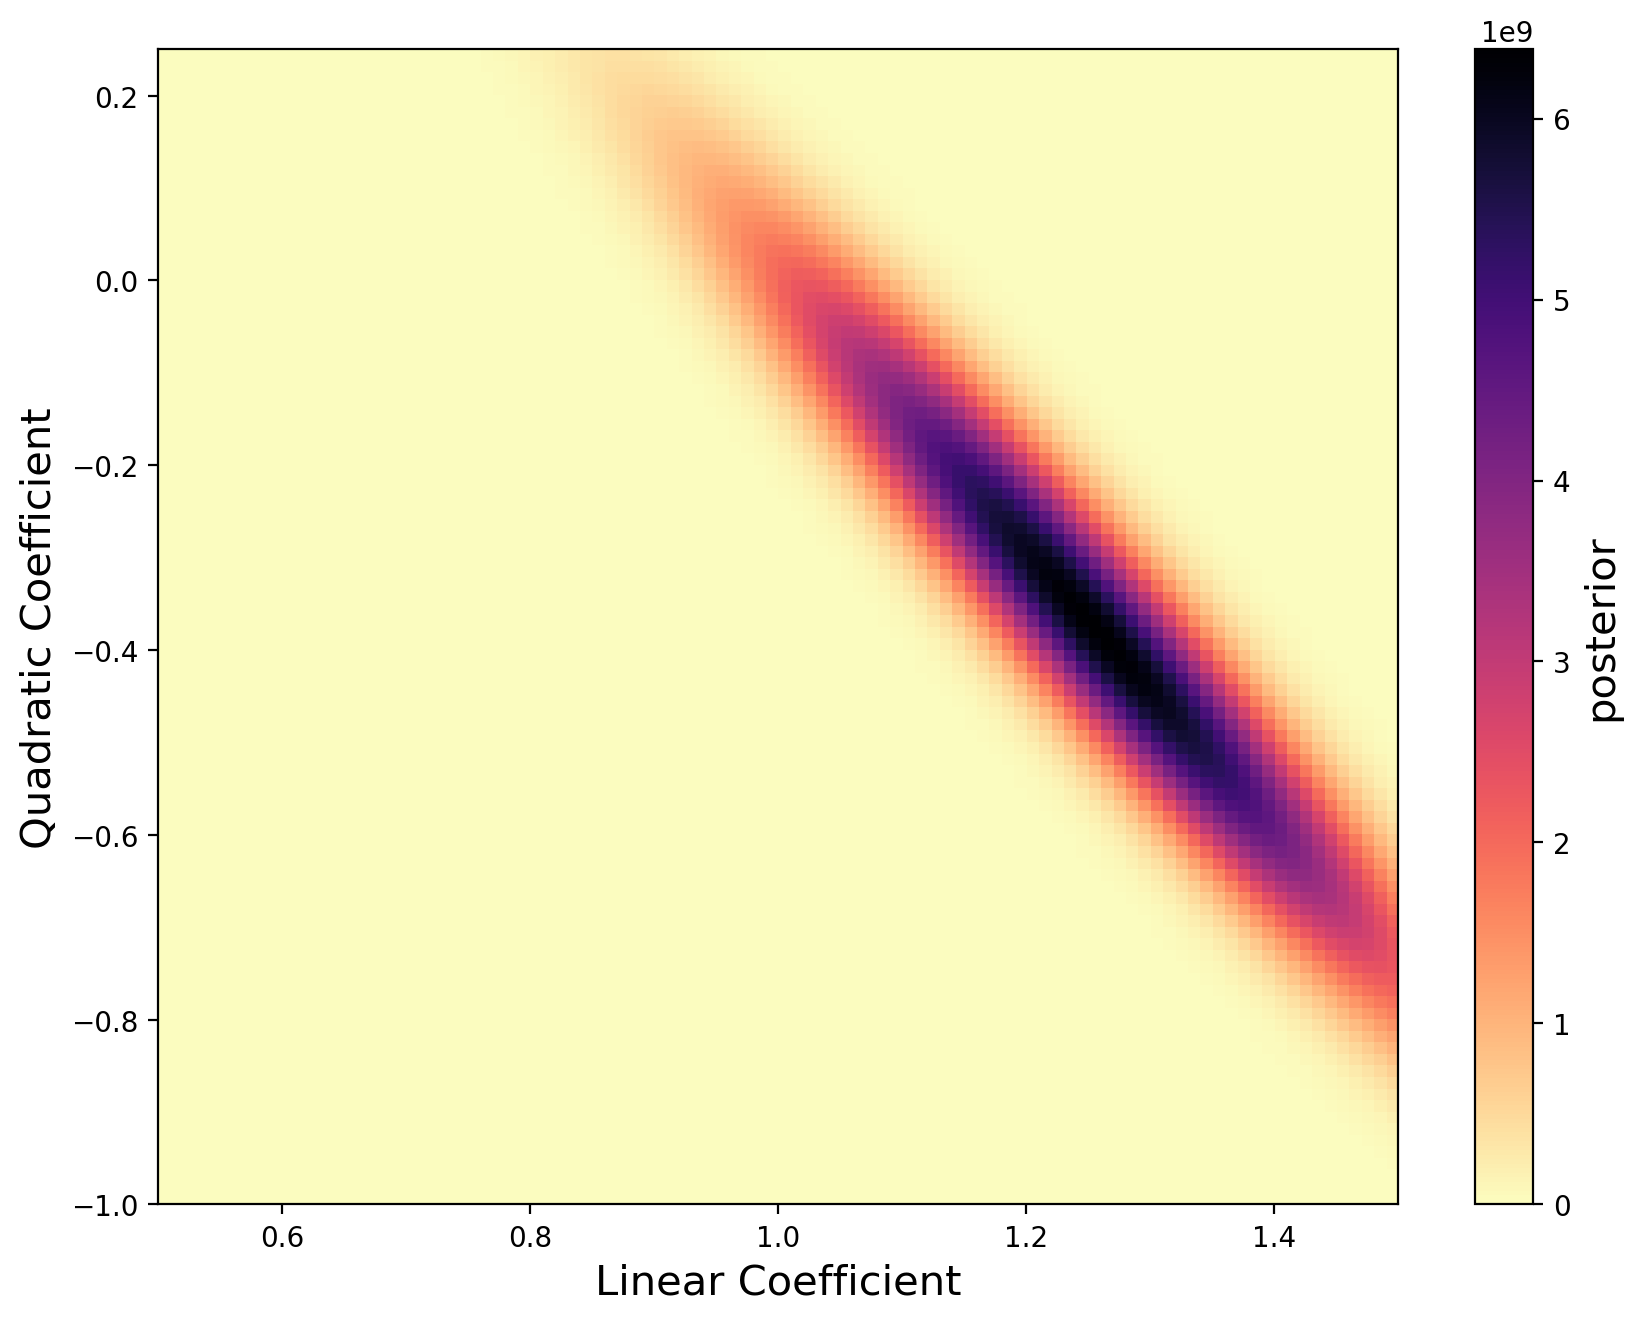

In [91]:
# MRS Plotting the 2D posterior distribution
# From Lecture 8
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 7.5))
plt.imshow(posterior, origin='lower',
           extent=(0.5, 1.5, -1, 0.25),
           cmap='magma_r',
           aspect='auto')
plt.colorbar().set_label(r'posterior', fontsize=15)


plt.xlabel(r'Linear Coefficient', fontsize=15)
plt.ylabel(r'Quadratic Coefficient', fontsize=15)

plt.show()

SRT: Nice

In [92]:
# MRS Calcualate the evidence of the 2D posterior distribution
evidence_quad = scipy.integrate.trapezoid(scipy.integrate.trapezoid(posterior, linear_coeff), quad_coeff)

In [93]:
# MRS Bayes Factor of the 2D vs 1D fit
baye_fact =evidence_quad / evidence
print(baye_fact)
print("The Bayes Factor favors the quadratic fit")

1.341137997143383
The Bayes Factor favors the quadratic fit


SRT: Terrific work


For $N$ data points and a model with $k$ parameters,

$${\rm BIC} \equiv -2 \ln [L_0(M)] + k \ln N.$$ 

In [94]:
# MRS Calculate the BIC for both the linear and quadratic fits
BIC_quad = -2*np.log(np.max(likelihood_gauss)) + 2*np.log(len(data[0, :]))
BIC_lin = -2*np.log(np.max(likelihood)) + np.log(len(data[0, :]))
print(f'Quadratic BIC: {BIC_quad:.2f} Linear BIC {BIC_lin:.2f}')
print('The BIC favors the linear model, but we know that the evidence is more robust and the quadratic is still figured.')

Quadratic BIC: -39.61 Linear BIC -40.56
The BIC favors the linear model, but we know that the evidence is more robust and the quadratic is still figured.


SRT: 50/50